In [38]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Загрузка данных
dataset = np.loadtxt('ParisHousing.csv', delimiter=',', skiprows=1)
X = dataset[:, 0:16]
y = dataset[:, 16]

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(16, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

train_mae_history = []
val_mae_history = []

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

X_train_split_tensor = torch.FloatTensor(X_train_split)
y_train_split_tensor = torch.FloatTensor(y_train_split)
X_val_split_tensor = torch.FloatTensor(X_val_split)
y_val_split_tensor = torch.FloatTensor(y_val_split)

for epoch in range(80):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        all_preds.extend(outputs.squeeze().detach().numpy())
        all_targets.extend(batch_y.numpy())

    train_mae = mean_absolute_error(all_targets, all_preds)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_split_tensor)
        val_mae = mean_absolute_error(y_val_split, val_outputs.squeeze().numpy())

    train_mae_history.append(train_mae)
    val_mae_history.append(val_mae)

    print(f'Epoch [{epoch+1}], Loss: {epoch_loss/len(train_loader):.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')

min_mae = min(val_mae_history)
min_epoch = val_mae_history.index(min_mae) + 1

print("\nМинимальный MAE:", min_mae)
print("Эпоха с минимальным MAE:", min_epoch)

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_mae = mean_absolute_error(y_test, test_outputs.squeeze().numpy())

print(f"MAE на тесте: {test_mae:.2f}")


Epoch [1], Loss: 32793847919411.1992, Train MAE: 4963869.9152, Val MAE: 5073500.6386
Epoch [2], Loss: 32756520294154.2383, Train MAE: 4961067.2050, Val MAE: 5068134.7799
Epoch [3], Loss: 32642980143431.6797, Train MAE: 4952759.6082, Val MAE: 5056279.4670
Epoch [4], Loss: 32433383505264.6406, Train MAE: 4937589.7470, Val MAE: 5036914.0164
Epoch [5], Loss: 32110355914424.3203, Train MAE: 4914243.1985, Val MAE: 5007979.9504
Epoch [6], Loss: 31652516312514.5586, Train MAE: 4881176.6664, Val MAE: 4969095.9775
Epoch [7], Loss: 31060485039718.3984, Train MAE: 4838128.4066, Val MAE: 4919525.3530
Epoch [8], Loss: 30328304806133.7617, Train MAE: 4784464.9459, Val MAE: 4858645.8282
Epoch [9], Loss: 29445843753369.6016, Train MAE: 4719200.7003, Val MAE: 4784718.3193
Epoch [10], Loss: 28381826858352.6406, Train MAE: 4639040.6836, Val MAE: 4693970.2603
Epoch [11], Loss: 27131735793991.6797, Train MAE: 4542866.8820, Val MAE: 4587373.5225
Epoch [12], Loss: 25716825192529.9219, Train MAE: 4431483.0146,

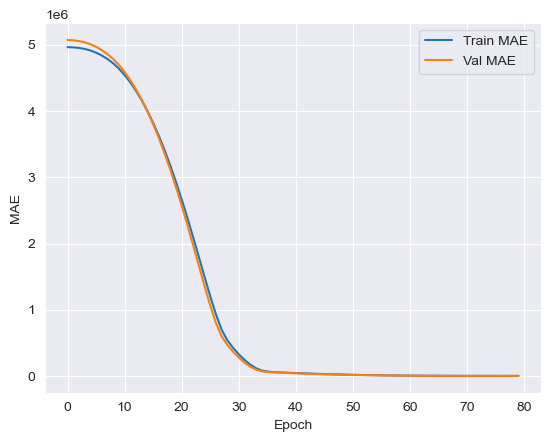

In [39]:
import matplotlib.pyplot as plt

plt.plot(train_mae_history, label='Train MAE')
plt.plot(val_mae_history, label='Val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()
